# figure 5, continuous 

In [1]:
import numpy as np
from scipy.integrate import odeint  
from operator import sub 
import controlpy   
import pickle

from matplotlib import  rc    
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import rcParams 

import sys 
import  os 

# append function path to system
base_path = os.path.abspath(os.path.join( os.getcwd()   , os.pardir ) )
function_path = os.path.join(  base_path, 'functions') 
sys.path.append(function_path ) 
 
figs_path = os.path.join(  base_path, 'figs') 
data_path = os.path.join(  base_path, 'data')
    
# import custom functions 
from figure_settings import *    
import figure_functions as ff
import phasediagram as phd
import singlependulum as sp  

In [2]:
# General Plotting Parameters  
fig_dim = (3.2,3)  
fig_name = 'fig5_continuous'
boost_col = 'c'
LQR_limit = 0.3

In [3]:
 
def pendulum_dynamics( y_n, t , K  ):
    L = 1. 
    mp = 1. 
    g = -10.
    b = 0.01
    y_f = np.array([np.pi,0]) 
    u = np.clip( np.dot( K,(y_f -y_n) ) ,-3,3)  
    
    fy = np.zeros(y_n.shape)    
    fy[0]=    y_n[1]  
    fy[1] =    mp*L*g/(mp*L**2)*np.sin( y_n[0] ) -b/(mp*L**2)*y_n[1] + u/(mp*L**2)
    return fy

In [4]:
# # visible_x = np.array([-1,1])*0.3+np.pi
dt = 0.01; 
tLast = 4
tInt = np.arange(0,tLast+dt, dt)     

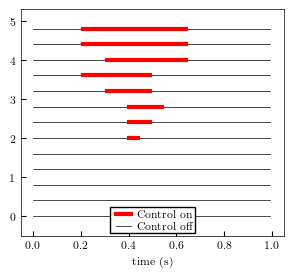

In [5]:
fig, ax  = plt.subplots(1,1,figsize= (3.4,3) ,dpi=100)  


def plot_line( ax_p, y_temp, u_temp, alpha = 0.05, line_col = line_col,linewidth=1):
    y0_i= np.where( y_temp[:,0] > -np.pi+0.3  )[0][0] + 1
    y1_i= np.where( y_temp[:,0] >  np.pi-0.3  )[0][0]
    y0 = y_temp[y0_i,:]
    
    x_u =  y_temp[y0_i:y1_i,0]
    y_u =   u_temp[y0_i:y1_i]*0.1 +  y0[1]
    
    bool_LQR1 = (np.abs(u_temp)>0.1) & (  np.arange( len(u_temp) )< (y0_i-1) )
    bool_LQR2 = (np.abs(u_temp)>0.1) & (  np.arange( len(u_temp) ) > (y1_i-1) )
    bool_ff = (np.abs(u_temp)>0.1) & (  np.arange( len(u_temp) )> (y0_i-1) ) & (  np.arange( len(u_temp) )< (y1_i-1) )
    
    ax_p.plot( y_temp[:,0], y_temp[:,1],
               linewidth = linewidth, color=line_col,zorder = -1 , alpha = alpha ) 
    ax_p.plot( y_temp[bool_LQR1,0], y_temp[bool_LQR1,1] ,
               linewidth = linewidth,  color=boost_col , alpha = alpha )
    ax_p.plot( y_temp[bool_LQR2,0], y_temp[bool_LQR2,1] ,
               linewidth = linewidth,   color= boost_col , alpha = alpha ) 
    ax_p.plot( y_temp[bool_ff,0], y_temp[bool_ff,1] ,
               linewidth = linewidth,     color=u_col , alpha = alpha )
    return( ax_p ) 


def plot_line_npy( ax_p ): 
    filename_learned = os.path.join( data_path,  'feedforward_grouping_learned.npy' )
    U_mat = np.load(filename_learned  )  

    for j in range( U_mat.shape[0] ): 
        y0 = U_mat[j,0]
        t1 = U_mat[j,1] 
        tau = U_mat[j,2]   
        t_end = 1.
        tInt = np.arange(0,t_end,dt) 
        u = np.zeros( (len(tInt) ))
        bool_on = (tInt>t1) & (tInt < (t1+tau) )
        u[bool_on]= -3

        ax_p.plot( tInt, u*0 + y0,'k',linewidth=0.5)
        ax_p.plot( tInt[bool_on], u[bool_on]*0+ y0, color=ff_col ,linewidth=3 ) 

        ax_p.set_ylim([-0.5, U_mat[-1,0]+0.5]) 
        ax_p.set_xlim([-0.05, 1.05]) 
        ax_p.set_xlabel('time (s) ') 
#         ax_p.yaxis.set_ticks([]) 
        
    
#     ax_p.yaxis.set_major_locator( plt.MultipleLocator(4) ) 
        
    ax_p.plot([-5,-5,],[-5,-4],color=ff_col,label='Control on',linewidth=3)
    ax_p.plot([-5,-5,],[-5,-4],'k',label='Control off',linewidth=0.5,)
    ax_p.legend( fontsize = 8,loc='lower center')
    
plot_line_npy( ax) 

In [6]:
 # xx = pickle.load('filename.pickle')
# with open('filename.pickle', 'rb') as handle:

# filename='feedforward_grouping_learned.npy'

filename_continuous = os.path.join( data_path,  'continuouslearning_data.pickle' )
with open( filename_continuous, 'rb') as handle:
    b = pickle.load(handle)
    
y_data = b[0]
u_data = b[1] 

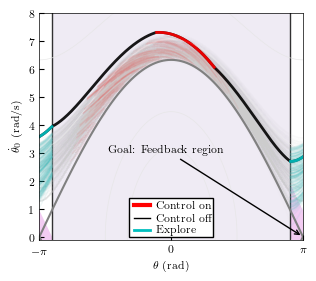

In [7]:
 

def plot_many_lines( ax_p):  
    n_lines = 265
    line_col = np.ones((3,))*0.8
    thin_line = np.ones((3))*0.8

    y_p = y_data 
    u_p = u_data 
    plot_array = []
    u_array = []
    split_locs = np.where( np.abs(np.diff( y_p[:,0]) ) > 6 )[0]
    split_locs = np.insert(split_locs,0,0)
    split_locs = np.insert(split_locs,len(split_locs),len(y_p) )  + 1
    for j in range(len(split_locs)-1 ): 
        plot_array.append( y_p[split_locs[j]:split_locs[j+1]  ,:] )  
        u_array.append( u_p[split_locs[j]:split_locs[j+1]   ] )  

    # AX  ---------------------------------------------
    for j in range( n_lines):
        y_temp = plot_array[j]
        u_temp = u_array[j ]
        plot_line(ax_p,y_temp, u_temp , line_col=thin_line ) 

    # do one highlight  ---------------------------------------------     
    j = n_lines + 61
    y_temp = plot_array[j]
    u_temp = u_array[j ] 
    plot_line(ax_p,y_temp, u_temp , alpha = 0.9, line_col='k',linewidth =2)

    phd.homoclinic_plot(ax_p,col=homoclinic_col) 
    ax_p.set_xlim( [-np.pi,np.pi])
    ax_p.set_ylim([-3,9])
 
    ax_p.set_xlim([-np.pi,np.pi ]) 
    
    ax_p.xaxis.set_major_locator(plt.MultipleLocator(np.pi )) 
    ax_p.xaxis.set_major_formatter(plt.FuncFormatter(phd.multiple_formatter()))  
    
    L = 20
    rectangle_order = -5
    rectangle1 = plt.Rectangle( ( -np.pi+0.3,-L/2), 2*np.pi-0.6,L, 
                                zorder=rectangle_order ,facecolor=obscure_col, edgecolor=obscure_edge ,alpha = obscure_alpha) 
    ax_p.add_patch(rectangle1)
    
        
    ax_p.plot([-5,-5,],[-5,-4],color=ff_col,label='Control on',linewidth=3)
    ax_p.plot([-5,-5,],[-5,-4],'k',label='Control off',linewidth=1 )
    ax_p.plot([-5,-5,],[-5,-4],color=boost_col,label='Explore',linewidth=2 )
    ax_p.legend(loc='lower center',fontsize = 8)
    
    
    ax_p.annotate('Goal: Feedback region', (np.pi,0), (-1.5,3),arrowprops=dict(arrowstyle='->') , fontsize = annotate_font) 

    dx =  LQR_limit 
    x_points = np.array([-dx, dx, dx, -dx])+np.pi
    y_points = np.array([1.,0,-1.,0])*1.88
    ax_p.fill( x_points-2*np.pi, y_points,facecolor=lqr_fill, zorder = -6,alpha=0.2 )
    ax_p.fill( x_points , y_points,facecolor=lqr_fill, zorder = -6,alpha=0.2,)

    

    ff.plot_add_contours(ax_p) 

    ax_p.set_xlabel(r'$\theta$ (rad)') 
    ax_p.set_ylabel(r'$\dot{\theta}$ (rad/s)')
    ax_p.set_ylim([-0.1,8])  

    ax_p.set_ylabel(r'$\dot{\theta}_0$ (rad/s)' )


    return( ax_p ) 

fig, ax  = plt.subplots(1,1,figsize= (3.4,3) ,dpi=100)  
plot_many_lines(ax)   

In [8]:
fig_dim = (3.2,1.8) 
fig = plt.figure( figsize= fig_dim,dpi = 100) 

ax = plt.axes([ 0 , 0 , .63 ,  1] )   
ax1= plt.axes([ .7, .0, .3 , 1] )    


plot_many_lines(ax)  
ax.yaxis.set_major_locator( plt.MultipleLocator(4) ) 
ax1.yaxis.set_major_locator( plt.MultipleLocator(4) ) 

plot_line_npy( ax1)   


ax1.set_ylabel( r'$\dot{\theta}_0$ (rad/s)' ,va='top'  )
yl = 9.5 
                 
label_dict = dict( fontsize = 8 , fontweight='bold' )   
# ff.label_axes(fig,labels =['a)','b)','c)','d)'], loc=(-0.15,.95 ) , **label_dict  ) 
ff.label_axes2(fig,labels =['a)','b)','c)','d)'], loc=(-0.2,0.92 ) , **label_dict   )
 
    
ff.save_fig( figs_path, fig_name)  

Saving to: D:\Mijn_documenten\Dropbox\A_PhD\C_Papers\ch_neuralControl\timed_feedforward_control\figs\fig5_continuous.png and .pdf
